## Notebook exploring the use of Hierarchical Attention Networks
Original Paper: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf

A Hierarchical Attention Network works on 3 layers, firstly a GRU is used to encode words in the sentence on a word layer, to which an Bahdanau Attention Mechanism is used to provide attention to the most important words in each sentence.

The second layer will involve encoding each sentence into its embedding with a GRU. A Bahdanau Attention Mechanism is also then used to provide attention to the most important sentence in the document.

The document vector is a summation of all the information of sentences in a document and passes through a linear layer to get classified.

For our use case, we explored both using a GRU and a LSTM. LSTMs could learn more complex patterns, but may cus the model to overcomplicate.

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, PackedSequence
from d2l import torch as d2l # You can skip this if you have trouble with this package, all d2l-related codes can be replaced by torch functions.
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np
import pandas as pd
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cheng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Data loading
A custom dataloader has to be built, as we need to break down each review into its individual sentences and words.

In [2]:
class IMDBDataset(Dataset):
    def __init__(self, 
                 data_dir:str,
                 max_sent_len:int,
                 max_doc_len:int, 
                 is_train:bool=True,
                 vocab:d2l.Vocab=None):
        """
        IMDB Dataset Class
        The dataset will be created by reading all documents inside the file, to which they will be preprocessed into lists of individual sentence and words for each review
        
        Args:
            data_dir (str): path to imdb parent folder
            max_sent_len (int): maximum number of words per sentence in review
            max_doc_len (int): maximum number of sentences per review
            is_train (bool, optional): is the dataset train? Will take from train folder if True. Defaults to True.
            vocab (d2l.Vocab, optional): d2l Vocab of train data, if None the vocab will be calculated. Defaults to None.
        """
        self.data_list, self.label_list = self._read_imdb(data_dir, is_train)
        self.max_sent_len = max_sent_len
        self.max_doc_len = max_doc_len
        self.vocab = d2l.Vocab(d2l.tokenize(self.data_list, token='word'), min_freq=5, reserved_tokens=['<pad>']) if vocab == None else vocab
    

    def _read_imdb(self, data_dir, is_train):
        data = []
        labels = []
        data_folder = 'train' if is_train else 'test'
        
        for label, label_folder in enumerate(['neg', 'pos']):
            # Retrieve full path
            full_path = os.path.join(data_dir, data_folder, label_folder)
            for text_file in os.listdir(full_path):
                # Read text
                with open(os.path.join(full_path, text_file), 'r', encoding='utf-8') as f:
                    # Add text and label
                    data.append(f.read())
                    labels.append(label)
        return data, labels


    def _transform_text(self, document:str):
        """
        Function to transform the dataset into the required format for HAN

        Args:
            document (str): the review

        Returns:
            doc: nested array of the review, in the format of [[word idx for each word in sentence], [next sentence], ...]
            num_sents: retrieve the number of sentences in document
            num_word: max number of words across all sentence in document
        """
        # Encoding document with max sentence length and maximum document length (num sentence)
        # Split into individual sentences in document
        sentences = sent_tokenize(document)
        doc = [self.vocab[word_tokenize(sentence)] for sentence in sentences]
        doc = [sent[:self.max_sent_len] for sent in doc][:self.max_doc_len]
        num_sents = min(len(doc), self.max_doc_len) # There is a limit of max_doc_len

        # skip erroneous ones
        if not num_sents:
            return None, -1, None

        num_words = [min(len(sent), self.max_sent_len) for sent in doc][:self.max_doc_len]
        return doc, num_sents, num_words

    
    def __len__(self):
        return len(self.data_list)


    def __getitem__(self, idx):
        doc_data = self.data_list[idx]
        doc, num_sents, num_words = self._transform_text(doc_data)
        if num_sents == -1:
            return None
        
        return doc, self.label_list[idx], num_sents, num_words

In [3]:
class padAnnotations():
  """
  Collate function to pad all sentences and words in sentences to the same length as max(len(sentences)) and max(len(words)) in a batch

  Args:
    pad_idx (int): Index Label for the <pad> token
  """
  def __init__(self, pad_idx):
    self.pad_idx = pad_idx

  def __call__(self, batch):
    batch = filter(lambda x: x is not None, batch)
    docs, labels, doc_lengths, sent_lengths = list(zip(*batch))

    batch_size = len(labels)
    batch_max_doc_length = max(doc_lengths) # maximum num sentence in a document in batch
    batch_max_sent_length = max([max(sl) if sl else 0 for sl in sent_lengths]) # maximum num words in a sentence in a document in a batch
    # Pad doc tensor to ensure all document have same num of sentence & num of words in each sentence
    # Pad sent lengths as all document may have different number of sentences, so need to ensure all doc hv same number of sentences 
    docs_tensor = torch.full((batch_size, batch_max_doc_length, batch_max_sent_length), self.pad_idx).long()
    sent_lengths_tensor = torch.full((batch_size, batch_max_doc_length), self.pad_idx).long()

    # Replace the values with the correct index, the rest remains as pads
    for doc_idx, doc in enumerate(docs):
        doc_length = doc_lengths[doc_idx]
        # Replace sentence lengths
        sent_lengths_tensor[doc_idx, :doc_length] = torch.tensor(sent_lengths[doc_idx], dtype=torch.long)
        for sent_idx, sent in enumerate(doc):
            # Replace document tensor
            sent_length = sent_lengths[doc_idx][sent_idx]
            docs_tensor[doc_idx, sent_idx, :sent_length] = torch.tensor(sent, dtype=torch.long)

    return (
        docs_tensor,
        torch.tensor(labels, dtype=torch.long),
        torch.tensor(doc_lengths, dtype=torch.long),
        sent_lengths_tensor,
    )

In [5]:
train_dataset = IMDBDataset(data_dir="../data/aclImdb",
                            max_sent_len=512,
                            max_doc_len=24)

test_dataset = IMDBDataset(data_dir="../data/aclImdb",
                            max_sent_len=512,
                            max_doc_len=24,
                            is_train=False,
                            vocab=train_dataset.vocab) #use train vocab

In [6]:
train_iter = DataLoader(train_dataset,
                        batch_size=64, 
                        shuffle=True,
                        collate_fn = padAnnotations(
                            pad_idx = train_dataset.vocab.token_to_idx["<pad>"], 
                        ))

test_iter = DataLoader(test_dataset,
                        batch_size=64, 
                        collate_fn = padAnnotations(
                            pad_idx = train_dataset.vocab.token_to_idx["<pad>"], 
                        ))

### Model Architecture

In [7]:
class WordAttention(torch.nn.Module):
    def __init__(
            self,
            device: str,
            vocab_size:int,
            embed_size: int,
            dropout: float,
            recurrent_size: int,
            attention_dim: int,
            lstm:bool=True
    ):
        """
        Word Embedding and Attention Class (Returns the sentence embedding which is the concat of word embeddings)

        Args:
            device (str): torch devide to train, eithe cuda:0 or cpu
            vocab_size (int): total len of vocab of dataset
            embed_size (int): embedding dimension 
            dropout (float): dropout probability (less than 1)
            recurrent_size (int): recurrent_size/2 will be lstm/gru output size 
            attention_dim (int): attention dimension
            lstm (bool, optional): boolean to use LSTM as encoder, if False, GRU will be used instead. Defaults to True
        """
        super().__init__()
        self._device = device
        self.embed_size = embed_size
        self.recurrent_size = recurrent_size
        self.dropout = dropout
        self.attention_dim = attention_dim

        assert self.recurrent_size % 2 == 0 #Bidirection

        # embedding layer
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embed_size)

        # Word Encoder, using LSTM or GRU according to lstm
        self.encoder = torch.nn.LSTM(
            input_size=self.embed_size,
            hidden_size=self.recurrent_size // 2,
            dropout=self.dropout,
            bidirectional=True,
            batch_first=True,
        ) if lstm else torch.nn.GRU(
            input_size=self.embed_size,
            hidden_size=self.recurrent_size // 2,
            dropout=self.dropout,
            bidirectional=True,
            batch_first=True, 
        )

        self.dropout = torch.nn.Dropout(dropout)

        # Maps Encoder output to `attention_dim` sized tensor
        self.word_weight = torch.nn.Linear(self.recurrent_size, self.attention_dim)

        # Word context vector (u_w) to take dot-product with
        self.context_weight = torch.nn.Linear(self.attention_dim, 1)
        

    def forward(self, docs, doc_lengths, sent_lengths):
        """
        Args:
            docs: Encoded document data of size (batch_size, padded_doc_length, padded_sent_length)
            doc_lengths: unpadded document lengths of size (num_docs)
            sent_lengths: unpadded sentence lengths of size (num_docs, max_sent_len)
        
        Returns:
            sentences embeddings, docs permutation indices, batch size, word attention weights
        """

        # Preprocessing to optimise computation by removing the pads ------------------------------------------------------------------
        # Sort documents by decreasing order in length
        doc_lengths, doc_perm_idx = doc_lengths.sort(dim=0, descending=True)
        docs = docs[doc_perm_idx]
        sent_lengths = sent_lengths[doc_perm_idx]

        # Make a long batch of sentences by removing pad-sentences
        # i.e. `docs` was of size (num_docs, padded_doc_length, padded_sent_length)
        # -> `packed_sents.data` is now of size (num_sents, padded_sent_length)
        packed_sents = pack_padded_sequence(docs, lengths=doc_lengths.tolist(), batch_first=True)

        # effective batch size at each timestep
        docs_valid_bsz = packed_sents.batch_sizes

        # Make a long batch of sentence lengths by removing pad-sentences
        # i.e. `sent_lengths` was of size (num_docs, padded_doc_length)
        # -> `packed_sent_lengths.data` is now of size (num_sents)
        packed_sent_lengths = pack_padded_sequence(sent_lengths, lengths=doc_lengths.tolist(), batch_first=True)

        # Retrieve sentence and its respective length
        sents, sent_lengths = packed_sents.data, packed_sent_lengths.data

        # Sort sents by decreasing order in sentence lengths
        sent_lengths, sent_perm_idx = sent_lengths.sort(dim=0, descending=True)
        sents = sents[sent_perm_idx]

        # Model Input --------------------------------------------------------------------------------------------------------------
        # Retrieve each word embedding
        inp = self.dropout(self.embedding(sents))
        
        # Make a long batch of words by removing pad-words
        # i.e. `inp` was of size (num_docs, padded_sent_length, embed_dim)
        # -> `packed_words.data` is now of size (num_words, embed_dim)        
        packed_words = pack_padded_sequence(inp, lengths=sent_lengths.tolist(), batch_first=True)

        # Effective batch size at each timestep
        sentences_valid_bsz = packed_words.batch_sizes

        # Apply word-level LSTM/GRU over word embeddings
        packed_words, _ = self.encoder(packed_words)

        # Calculate word attention
        u_i = torch.tanh(self.word_weight(packed_words.data))
        u_w = self.context_weight(u_i).squeeze(1)
        val = u_w.max()
        att = torch.exp(u_w - val)

        # Restore as sentences by repadding
        att, _ = pad_packed_sequence(PackedSequence(att, sentences_valid_bsz), batch_first=True)

        att_weights = att / torch.sum(att, dim=1, keepdim=True)

        # Restore as sentences by repadding
        sents, _ = pad_packed_sequence(packed_words, batch_first=True)

        # Apply attention weights
        sents = sents * att_weights.unsqueeze(2)
        sents = sents.sum(dim=1)

        # Restore the original order of sentences (undo the first sorting)
        _, sent_unperm_idx = sent_perm_idx.sort(dim=0, descending=False)
        sents = sents[sent_unperm_idx]

        # Restore back the original order
        att_weights = att_weights[sent_unperm_idx]

        return sents, doc_perm_idx, docs_valid_bsz, att_weights

In [8]:
class SentenceAttention(torch.nn.Module):
    def __init__(
            self,
            device: str,
            dropout: float,
            word_recurrent_size: int,
            recurrent_size: int,
            attention_dim: int,
            lstm:bool=True
    ):
        """
        Sentence Embedding and Attention Class (Returns the document embedding which is the concat of sentence embeddings)

        Args:
            device (str): torch devide to train, eithe cuda:0 or cpu
            dropout (float): dropout probability (less than 1)
            word_recurrent_size (int): recurrent size for WordAttention Class
            recurrent_size (int): recurrent_size/2 will be lstm/gru output size 
            attention_dim (int): attention dimension
            lstm (bool, optional): boolean to use LSTM as encoder, if False, GRU will be used instead. Defaults to True
        """
        super().__init__()
        self._device = device
        self.word_recurrent_size = word_recurrent_size
        self.recurrent_size = recurrent_size
        self.dropout = dropout
        self.attention_dim = attention_dim
            
        assert self.recurrent_size % 2 == 0 #Bidirection

        # Sentence Encoder, using LSTM or GRU according to lstm
        self.encoder = torch.nn.LSTM(
            input_size=self.word_recurrent_size,
            hidden_size=self.recurrent_size // 2,
            dropout=self.dropout,
            bidirectional=True,
            batch_first=True,
        ) if lstm else torch.nn.GRU(
            input_size=self.word_recurrent_size,
            hidden_size=self.recurrent_size // 2,
            dropout=self.dropout,
            bidirectional=True,
            batch_first=True,
        )

        self.dropout = torch.nn.Dropout(dropout)

        # Maps Encoder output to `attention_dim` sized tensor
        self.sentence_weight = torch.nn.Linear(self.recurrent_size, self.attention_dim)

        # Word context vector (u_w) to take dot-product with
        self.sentence_context_weight = torch.nn.Linear(self.attention_dim, 1)


    def forward(self, sent_embeddings, doc_perm_idx, doc_valid_bsz, word_att_weights):
        """
        Args:
            sent_embeddings: Sentence embeddings from WordAttention of size (batch_size * padded_doc_length, sentence recurrent dim)
            doc_perm_idx: Document Permutation Index of each document, of size (batch_size)
            doc_valid_bsz: Batch Size
            word_att_weights: Word attention weights from WordAttention Class of size (batch_size * padded_doc_length, max_sent_len)
        Returns:
            docs embeddings, word attention weights, sentence attention weights
        """
        # Apply dropout to sentence embedding from Word Attention class
        sent_embeddings = self.dropout(sent_embeddings)

        # Sentence-level LSTM/GRU over sentence embeddings
        packed_sentences, _ = self.encoder(PackedSequence(sent_embeddings, doc_valid_bsz))

        # Calculate sentence attention
        u_i = torch.tanh(self.sentence_weight(packed_sentences.data))
        u_w = self.sentence_context_weight(u_i).squeeze(1)
        val = u_w.max()
        att = torch.exp(u_w - val)

        # Restore as sentences by repadding
        att, _ = pad_packed_sequence(PackedSequence(att, doc_valid_bsz), batch_first=True)

        sent_att_weights = att / torch.sum(att, dim=1, keepdim=True)

        # Restore as documents by repadding
        docs, _ = pad_packed_sequence(packed_sentences, batch_first=True)

        # Compute document vectors
        docs = docs * sent_att_weights.unsqueeze(2)
        docs = docs.sum(dim=1)

        # Restore as documents by repadding
        word_att_weights, _ = pad_packed_sequence(PackedSequence(word_att_weights, doc_valid_bsz), batch_first=True)

        # Restore the original order of documents (undo the first sorting)
        _, doc_unperm_idx = doc_perm_idx.sort(dim=0, descending=False)
        docs = docs[doc_unperm_idx]

        # Restore back the original order
        word_att_weights = word_att_weights[doc_unperm_idx]
        sent_att_weights = sent_att_weights[doc_unperm_idx]

        return docs, word_att_weights, sent_att_weights

In [9]:
class HANModel(torch.nn.Module):
    def __init__(self, 
                 device:str, 
                 vocab:d2l.Vocab,
                 final_layer_dim:int, 
                 num_class:int,
                 lstm:bool=True
                 ):
        """
        Hierarchical Attention Network Model
        Runs WordAttentionModel, followed by SentenceAttentionModel and the final linear layer for classification of the document embeddings. 

        Args:
            device (str): torch devide to train, eithe cuda:0 or cpu
            vocab (d2l.Vocab): dataset Vocab class
            final_layer_dim (int): classification linear layer dimension
            num_class (int): total number of class for final output
            lstm (bool, optional): boolean to use LSTM as encoder for WordAttention and SentenceAttention, if False, GRU will be used instead. Defaults to True
        """
        super().__init__()

        self.word_attention = WordAttention(
            device=device,
            dropout=0.2,
            vocab_size=len(vocab),
            embed_size=100,
            recurrent_size=256,
            attention_dim=256,
            lstm=lstm
            )

        self.sentence_attention = SentenceAttention(
            device=device,
            dropout=0.2,
            word_recurrent_size=256,
            recurrent_size=256,
            attention_dim=256,
            lstm=lstm
        )

        self.linear = torch.nn.Linear(self.sentence_attention.recurrent_size, final_layer_dim)
        self.fc = torch.nn.Linear(final_layer_dim, num_class)
        self.relu = torch.nn.ReLU()


    def forward(self, docs, doc_lengths, sent_lengths):
        """
        Args:
            docs: Encoded document data of size (batch_size, padded_doc_length, padded_sent_length)
            doc_lengths: unpadded document lengths of size (num_docs)
            sent_lengths: unpadded sentence lengths of size (num_docs, max_sent_len)
        
        Returns:
            class scores, attention weights of words, attention weights of sentences, loss
        """

        # Retrieve sentence embedding for each sentence by passing it in the word attention model
        sent_embeddings, doc_perm_idx, docs_valid_bsz, word_att_weights = self.word_attention(
            docs, doc_lengths, sent_lengths
        )

        # Retrieve document embedding for each document by passing the sentence embeddings in the sentence attention model
        doc_embeds, word_att_weights, sentence_att_weights = self.sentence_attention(
            sent_embeddings, doc_perm_idx, docs_valid_bsz, word_att_weights
        )

        # Classify and get class score
        doc_scores = self.relu(self.linear(doc_embeds))
        scores = self.fc(doc_scores)

        outputs = (scores, word_att_weights, sentence_att_weights)

        return outputs

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = HANModel(device=device,
                 vocab=train_dataset.vocab,
                 final_layer_dim=50,
                 num_class=2,
                 lstm=True)
print(lstm_model)

HANModel(
  (word_attention): WordAttention(
    (embedding): Embedding(49347, 100)
    (encoder): LSTM(100, 128, batch_first=True, dropout=0.2, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (word_weight): Linear(in_features=256, out_features=256, bias=True)
    (context_weight): Linear(in_features=256, out_features=1, bias=True)
  )
  (sentence_attention): SentenceAttention(
    (encoder): LSTM(256, 128, batch_first=True, dropout=0.2, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (sentence_weight): Linear(in_features=256, out_features=256, bias=True)
    (sentence_context_weight): Linear(in_features=256, out_features=1, bias=True)
  )
  (linear): Linear(in_features=256, out_features=50, bias=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
)


c:\Users\cheng\Desktop\SUTD\Term_7\NLP\Final Project\myenv\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gru_model = HANModel(device=device,
                 vocab=train_dataset.vocab,
                 final_layer_dim=50,
                 num_class=2,
                 lstm=False)
print(gru_model)

HANModel(
  (word_attention): WordAttention(
    (embedding): Embedding(49347, 100)
    (encoder): GRU(100, 128, batch_first=True, dropout=0.2, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (word_weight): Linear(in_features=256, out_features=256, bias=True)
    (context_weight): Linear(in_features=256, out_features=1, bias=True)
  )
  (sentence_attention): SentenceAttention(
    (encoder): GRU(256, 128, batch_first=True, dropout=0.2, bidirectional=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (sentence_weight): Linear(in_features=256, out_features=256, bias=True)
    (sentence_context_weight): Linear(in_features=256, out_features=1, bias=True)
  )
  (linear): Linear(in_features=256, out_features=50, bias=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
)


### Training and Evaluation

In [12]:
# Replacing embedding with glove_embedding
def use_glove_embedding(model:HANModel, vocab:d2l.Vocab):
    """
    Function to embed glove6b.100d word embedding into embedding layer of HANModel (in word_attention)
    Args:
        model (HANModel): Instance of HANModel class
        vocab (d2l.Vocab): Train dataset vocab class

    Returns:
        model with updated embedding layer
    """

    # Retrieve embedding
    glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
    embeds = glove_embedding[vocab.idx_to_token]
    # Apply embedding and set grad to False to prevent training
    model.word_attention.embedding.weight.data.copy_(embeds)
    model.word_attention.embedding.weight.requires_grad = False

    return model

In [13]:
def eval_model(model:HANModel,
               test_iter:DataLoader,
               device:str,
               vocab: d2l.Vocab,
               calc_confusion_matrix:bool=False,
               download_results:bool=False,
               result_path:str=None,
               ):
    
    """
    Function to evaluate model, returning the Accuracy, Precision, Recall and F1 score

    Args:
        model (HANModel): Instance of model
        test_iter (DataLoader): test dataloader
        device (str): cpu or cuda
        vocab (d2l.Vocab): dataset vocab
        calc_confusion_matrix (bool, Optional): Boolean if Precision, Recall and F1 score should also be calculated. Defaults to False.
        download_results (bool, Optional): Boolean to save predictions into a csv file. Defaults to False.
        result_path (str, Optional): CSV filepath for results
    
    Returns:
        accuracy, recall (None if calc_confusion_matrix == False), precision (None if calc_confusion_matrix == False), f1 (None if calc_confusion_matrix == False)
    """
    if download_results and result_path == None and '.csv' not in result_path:
        raise Exception("Invalid result filepath")

    prediction_list = []
    actual_list = []

    # For donwload results
    sentence_list = []
    predicted_labels = []
    actual_labels = []

    recall, precision, f1 = None, None, None

    # Setup model eval to prevent training
    model.eval()
    for idx, (doc, label, num_sents, num_words) in tqdm(enumerate(test_iter), total=len(test_iter)):
        # Append actual scores
        actual_list.append(label.numpy())
        doc, label, num_sents, num_words = doc.to(device), label.to(device), num_sents.to(device), num_words.to(device)
        scores, word_att_weights, sentence_att_weights = model(doc, num_sents, num_words)
        # Append predicted scores
        _, predicted = torch.max(scores, dim=1)
        prediction_list.append(predicted.cpu().numpy())

        # Append results
        if download_results:
            # Sentence
            for sent in doc.cpu().numpy():
                pad_index = vocab.token_to_idx["<pad>"]
                # Convert list of sentences into a single sentence
                flattened_sent = sent.flatten().tolist()
                # Extract pad tokens
                cleaned_sents = [token for token in flattened_sent if token != pad_index]
                word_tokens = vocab.to_tokens(cleaned_sents)
                sentence_list.append(" ".join(word_tokens))
            # Labels
            predicted_labels.extend(["negative" if pred == 0 else "positive" for pred in predicted.cpu().numpy()])
            actual_labels.extend(["negative" if pred == 0 else "positive" for pred in label.cpu().numpy()])


    # Flatten the lists into arrays
    actual_list = np.concatenate(actual_list)
    prediction_list = np.concatenate(prediction_list)

    # Calculate accuracy
    accuracy = accuracy_score(actual_list, prediction_list)

    # Calculate other metrics
    if calc_confusion_matrix:
        recall = recall_score(actual_list, prediction_list)
        precision = precision_score(actual_list, prediction_list)
        f1 = f1_score(actual_list, prediction_list)

    # Download results
    if download_results:
        data = pd.DataFrame({
            'Sentence': sentence_list,
            'Actual': actual_labels,
            "Predicted": predicted_labels
        })

        data.to_csv(result_path, index=False)
        
    return accuracy, recall, precision, f1

In [14]:
def train_model(model:HANModel, 
                train_iter:DataLoader, 
                test_iter:DataLoader, 
                vocab: d2l.Vocab,
                num_epochs:int, 
                criterion, 
                optimiser, 
                lr_scheduler, 
                clip_grad:int, 
                device:str,
                show_training_graph:bool,
                best_model_path:str, 
                final_model_path:str):
    
    """
    Function to train and evaluate model
    The model will train on the train_iter, be evaluated on test_iter
    Best model with highest accuracy on test_iter will be saved in best_model_path
    Final model after last epoch will be saved in final_model_path

    Args:
        model (HANModel): model to be trained
        train_iter (DataLoader): train dataset
        test_iter (DataLoader): test dataset
        vocab (d2l.Vocab): dataset vocab
        num_epochs (int): Number of epochs to train
        criterion: criterion (loss) function
        optimiser: optimiser
        lr_scheduler: learning rate scheduler, else None
        clip_grad (int): maximum gradient, to prevent exploding gradient problem
        device (str): cpu or cuda
        show_training_graph (bool): boolean to show the training loss, training acc and test acc graph across epochs
        best_model_path (str): path to best model
        final_model_path (str): path to model aft final epoch training
    """
    train_loss_container = []
    train_acc_container = []
    test_acc_container = []

    best_test_acc = 0

    for epoch in range(num_epochs):
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0

        # Setup training 
        model.train()
        model.to(device)

        for idx, (doc, label, num_sents, num_words) in tqdm(enumerate(train_iter), total=len(train_iter)):
            doc, label, num_sents, num_words = doc.to(device), label.to(device), num_sents.to(device), num_words.to(device)

            # Get predictions and loss
            scores, word_att_weights, sentence_att_weights = model(doc, num_sents, num_words)
            loss = criterion(scores, label)
            total_train_loss += loss.item()

            # Train
            optimiser.zero_grad()
            loss.backward()
            if clip_grad:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad) # Clip gradient to prevent exploding gradient
            optimiser.step()
            if lr_scheduler:
                lr_scheduler.step()

            # Count accuracy
            _, predicted = torch.max(scores, dim=1)
            total_train_correct += (predicted == label).sum().item()
            total_train_samples += label.shape[0]

        # Evaluation for test
        test_acc, _, _, _ = eval_model(model, test_iter, device, vocab)

        train_loss_container.append(total_train_loss/len(train_iter)) #total num of batches
        train_acc_container.append(total_train_correct/total_train_samples)
        test_acc_container.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model, best_model_path)
            print(f"Best Model Saved at epoch {epoch+1}")

        print(f"Epoch {epoch+1} completed, train_loss: {total_train_loss/len(train_iter)}, train_acc: {total_train_correct/total_train_samples}, test_acc: {test_acc}")

    # Save Final model 
    torch.save(model, final_model_path)

    if show_training_graph:
        # Graph with matplotlib
        # Plot each list
        plt.plot(train_loss_container, label='Train Loss', color='blue')
        plt.plot(train_acc_container, label='Train Acc', color='green')
        plt.plot(test_acc_container, label='Test Acc', color='red')

        # Add labels and legend
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()


In [17]:
import gc
gc.collect()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lstm_model = HANModel(device=device,
                 vocab=train_dataset.vocab,
                 final_layer_dim=50,
                 num_class=2,
                 lstm=True)

gru_model = HANModel(device=device,
                 vocab=train_dataset.vocab,
                 final_layer_dim=50,
                 num_class=2,
                 lstm=False)

lstm_model = use_glove_embedding(lstm_model, train_dataset.vocab)
gru_model = use_glove_embedding(gru_model, train_dataset.vocab)

c:\Users\cheng\Desktop\SUTD\Term_7\NLP\Final Project\myenv\lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


### LSTM

100%|██████████| 782/782 [00:38<00:00, 20.21it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.42551544243874756, train_acc: 0.79976, test_acc: 0.82


100%|██████████| 782/782 [00:38<00:00, 20.25it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.34208784513461316, train_acc: 0.85264, test_acc: 0.86848


100%|██████████| 782/782 [00:39<00:00, 19.82it/s]


Epoch 3 completed, train_loss: 0.31861173568288687, train_acc: 0.86448, test_acc: 0.86264


100%|██████████| 782/782 [00:38<00:00, 20.18it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.30190427455565205, train_acc: 0.87304, test_acc: 0.88324


100%|██████████| 782/782 [00:38<00:00, 20.37it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.2877035250749125, train_acc: 0.87872, test_acc: 0.88476


100%|██████████| 782/782 [00:38<00:00, 20.15it/s]


Best Model Saved at epoch 6
Epoch 6 completed, train_loss: 0.27170283163485626, train_acc: 0.88592, test_acc: 0.8912


100%|██████████| 782/782 [00:39<00:00, 19.95it/s]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.25676111033772264, train_acc: 0.8954, test_acc: 0.89416


100%|██████████| 782/782 [00:38<00:00, 20.08it/s]


Epoch 8 completed, train_loss: 0.25132979101041697, train_acc: 0.89624, test_acc: 0.89204


100%|██████████| 782/782 [00:39<00:00, 19.91it/s]


Epoch 9 completed, train_loss: 0.24084112057438517, train_acc: 0.90336, test_acc: 0.89396


100%|██████████| 782/782 [00:37<00:00, 20.67it/s]


Best Model Saved at epoch 10
Epoch 10 completed, train_loss: 0.22834335460477626, train_acc: 0.90824, test_acc: 0.89676


100%|██████████| 782/782 [00:37<00:00, 20.75it/s]


Best Model Saved at epoch 11
Epoch 11 completed, train_loss: 0.2158221222336411, train_acc: 0.91288, test_acc: 0.89928


100%|██████████| 782/782 [00:38<00:00, 20.39it/s]


Epoch 12 completed, train_loss: 0.20565969163261336, train_acc: 0.91816, test_acc: 0.89252


100%|██████████| 782/782 [00:39<00:00, 19.97it/s]


Best Model Saved at epoch 13
Epoch 13 completed, train_loss: 0.19518022806457508, train_acc: 0.9224, test_acc: 0.89992


100%|██████████| 782/782 [00:39<00:00, 19.74it/s]


Epoch 14 completed, train_loss: 0.18426312249191962, train_acc: 0.92796, test_acc: 0.89772


100%|██████████| 782/782 [00:38<00:00, 20.15it/s]


Best Model Saved at epoch 15
Epoch 15 completed, train_loss: 0.17757519114228998, train_acc: 0.9282, test_acc: 0.90164


100%|██████████| 782/782 [00:38<00:00, 20.52it/s]


Epoch 16 completed, train_loss: 0.16783757745157307, train_acc: 0.9338, test_acc: 0.89616


100%|██████████| 782/782 [00:37<00:00, 20.59it/s]


Epoch 17 completed, train_loss: 0.16059617106052462, train_acc: 0.93744, test_acc: 0.893


100%|██████████| 782/782 [00:38<00:00, 20.42it/s]


Epoch 18 completed, train_loss: 0.15152577449427085, train_acc: 0.94272, test_acc: 0.9012


100%|██████████| 782/782 [00:37<00:00, 20.64it/s]


Best Model Saved at epoch 19
Epoch 19 completed, train_loss: 0.14052652435310548, train_acc: 0.94588, test_acc: 0.90236


100%|██████████| 782/782 [00:37<00:00, 20.75it/s]


Epoch 20 completed, train_loss: 0.13548602736162027, train_acc: 0.94916, test_acc: 0.90196


100%|██████████| 782/782 [00:37<00:00, 20.70it/s]


Epoch 21 completed, train_loss: 0.12534497672146486, train_acc: 0.95268, test_acc: 0.8992


100%|██████████| 782/782 [00:37<00:00, 20.63it/s]


Epoch 22 completed, train_loss: 0.12484171859505575, train_acc: 0.95312, test_acc: 0.90064


100%|██████████| 782/782 [00:37<00:00, 20.66it/s]


Epoch 23 completed, train_loss: 0.11212892082217328, train_acc: 0.95788, test_acc: 0.90216


100%|██████████| 782/782 [00:38<00:00, 20.10it/s]


Epoch 24 completed, train_loss: 0.1044302257322742, train_acc: 0.96116, test_acc: 0.90188


100%|██████████| 782/782 [00:39<00:00, 19.87it/s]


Epoch 25 completed, train_loss: 0.10250159246844652, train_acc: 0.962, test_acc: 0.8952


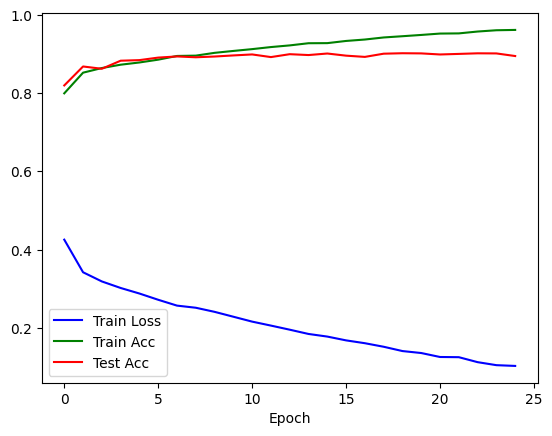

In [ ]:
#256, 24, 32
lr, num_epochs = 0.005, 25

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=25)

train_model(lstm_model, train_iter, test_iter, train_dataset.vocab, num_epochs, criterion, optimizer, scheduler, 1, device, True, '../models/best_LSTM_256_32_HAN.pt', '../models/final_LSTM_256_32_HAN.pt')

100%|██████████| 391/391 [00:35<00:00, 11.05it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.6638665969109596, train_acc: 0.55928, test_acc: 0.7176


100%|██████████| 391/391 [00:35<00:00, 11.00it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.4189311152757586, train_acc: 0.81208, test_acc: 0.85392


100%|██████████| 391/391 [00:36<00:00, 10.77it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.35229103694029174, train_acc: 0.84768, test_acc: 0.86584


100%|██████████| 391/391 [00:35<00:00, 11.03it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.31732241900833064, train_acc: 0.86548, test_acc: 0.87592


100%|██████████| 391/391 [00:34<00:00, 11.22it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.30228004385443297, train_acc: 0.8706, test_acc: 0.8824


100%|██████████| 391/391 [00:34<00:00, 11.17it/s]


Epoch 6 completed, train_loss: 0.2916753530083105, train_acc: 0.87588, test_acc: 0.88224


100%|██████████| 391/391 [00:37<00:00, 10.46it/s]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.2797872643260395, train_acc: 0.8814, test_acc: 0.88836


100%|██████████| 391/391 [00:34<00:00, 11.33it/s]


Epoch 8 completed, train_loss: 0.26682791052876836, train_acc: 0.88872, test_acc: 0.87812


100%|██████████| 391/391 [00:35<00:00, 10.99it/s]


Best Model Saved at epoch 9
Epoch 9 completed, train_loss: 0.25628169734612144, train_acc: 0.89348, test_acc: 0.89296


100%|██████████| 391/391 [00:34<00:00, 11.18it/s]


Epoch 10 completed, train_loss: 0.24803590162864428, train_acc: 0.89628, test_acc: 0.88924


100%|██████████| 391/391 [00:33<00:00, 11.74it/s]


Best Model Saved at epoch 11
Epoch 11 completed, train_loss: 0.24051126378500248, train_acc: 0.90072, test_acc: 0.89648


100%|██████████| 391/391 [00:33<00:00, 11.52it/s]


Best Model Saved at epoch 12
Epoch 12 completed, train_loss: 0.22935409626692457, train_acc: 0.90528, test_acc: 0.89692


100%|██████████| 391/391 [00:34<00:00, 11.28it/s]


Epoch 13 completed, train_loss: 0.22382926216820623, train_acc: 0.90836, test_acc: 0.89616


100%|██████████| 391/391 [00:33<00:00, 11.52it/s]


Epoch 14 completed, train_loss: 0.21162812394635452, train_acc: 0.91516, test_acc: 0.8806


100%|██████████| 391/391 [00:33<00:00, 11.74it/s]


Best Model Saved at epoch 15
Epoch 15 completed, train_loss: 0.2026471913318195, train_acc: 0.91868, test_acc: 0.89772


100%|██████████| 391/391 [00:35<00:00, 11.06it/s]


Best Model Saved at epoch 16
Epoch 16 completed, train_loss: 0.19353640979856176, train_acc: 0.92196, test_acc: 0.89848


100%|██████████| 391/391 [00:33<00:00, 11.59it/s]


Best Model Saved at epoch 17
Epoch 17 completed, train_loss: 0.18492775232247685, train_acc: 0.92516, test_acc: 0.90056


100%|██████████| 391/391 [00:33<00:00, 11.68it/s]


Epoch 18 completed, train_loss: 0.1808618502429379, train_acc: 0.92788, test_acc: 0.88932


100%|██████████| 391/391 [00:33<00:00, 11.85it/s]


Epoch 19 completed, train_loss: 0.17080995286136028, train_acc: 0.9332, test_acc: 0.8898


100%|██████████| 391/391 [00:33<00:00, 11.69it/s]


Epoch 20 completed, train_loss: 0.16243025074567635, train_acc: 0.93516, test_acc: 0.89572


100%|██████████| 391/391 [00:33<00:00, 11.76it/s]


Best Model Saved at epoch 21
Epoch 21 completed, train_loss: 0.15592902131816921, train_acc: 0.93864, test_acc: 0.90276


100%|██████████| 391/391 [00:32<00:00, 11.85it/s]


Epoch 22 completed, train_loss: 0.14852130734135427, train_acc: 0.94148, test_acc: 0.89844


100%|██████████| 391/391 [00:33<00:00, 11.64it/s]


Epoch 23 completed, train_loss: 0.14247743967358414, train_acc: 0.94356, test_acc: 0.89756


100%|██████████| 391/391 [00:33<00:00, 11.85it/s]


Epoch 24 completed, train_loss: 0.13725388416891818, train_acc: 0.94568, test_acc: 0.8988


100%|██████████| 391/391 [00:33<00:00, 11.68it/s]


Epoch 25 completed, train_loss: 0.1275423544761546, train_acc: 0.94988, test_acc: 0.89928


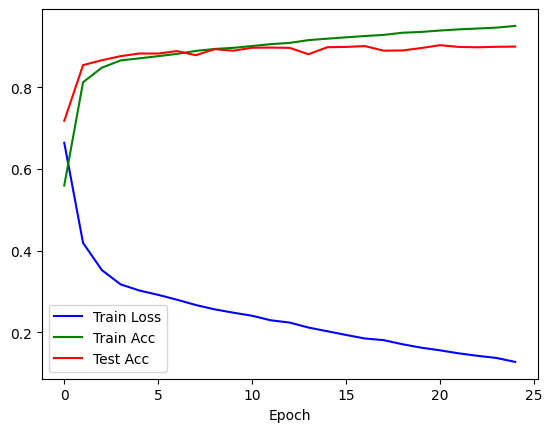

In [ ]:
#256, 24, 64
lr, num_epochs = 0.005, 25

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=25)

train_model(lstm_model, train_iter, test_iter, train_dataset.vocab, num_epochs, criterion, optimizer, scheduler, 1, device, True, '../models/best_LSTM_256_64_HAN.pt', '../models/final_LSTM_256_64_HAN.pt')

100%|██████████| 782/782 [00:39<00:00, 19.63it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.4398760174012855, train_acc: 0.79176, test_acc: 0.8514


100%|██████████| 782/782 [00:38<00:00, 20.28it/s]


Epoch 2 completed, train_loss: 0.3465458523872716, train_acc: 0.85148, test_acc: 0.84952


100%|██████████| 782/782 [00:39<00:00, 19.92it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.31994550524617704, train_acc: 0.8632, test_acc: 0.87516


100%|██████████| 782/782 [00:39<00:00, 19.79it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.3025610531820818, train_acc: 0.87084, test_acc: 0.88444


100%|██████████| 782/782 [00:39<00:00, 19.73it/s]


Epoch 5 completed, train_loss: 0.2835938271106509, train_acc: 0.87992, test_acc: 0.87224


100%|██████████| 782/782 [00:39<00:00, 19.89it/s]


Best Model Saved at epoch 6
Epoch 6 completed, train_loss: 0.27113983952595144, train_acc: 0.88612, test_acc: 0.88912


100%|██████████| 782/782 [00:39<00:00, 19.82it/s]


Epoch 7 completed, train_loss: 0.25622288278682764, train_acc: 0.89408, test_acc: 0.88904


100%|██████████| 782/782 [00:37<00:00, 20.68it/s]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.2453648623631662, train_acc: 0.90084, test_acc: 0.89352


100%|██████████| 782/782 [00:37<00:00, 20.74it/s]


Best Model Saved at epoch 9
Epoch 9 completed, train_loss: 0.2307693788643612, train_acc: 0.90592, test_acc: 0.8962


100%|██████████| 782/782 [00:38<00:00, 20.49it/s]


Epoch 10 completed, train_loss: 0.22329062098622932, train_acc: 0.90876, test_acc: 0.89528


100%|██████████| 782/782 [00:38<00:00, 20.44it/s]


Best Model Saved at epoch 11
Epoch 11 completed, train_loss: 0.21232951318135346, train_acc: 0.91204, test_acc: 0.89764


100%|██████████| 782/782 [00:37<00:00, 20.81it/s]


Epoch 12 completed, train_loss: 0.19587498538843964, train_acc: 0.92152, test_acc: 0.89316


100%|██████████| 782/782 [00:37<00:00, 20.78it/s]


Epoch 13 completed, train_loss: 0.18794585779652268, train_acc: 0.92624, test_acc: 0.89732


100%|██████████| 782/782 [00:37<00:00, 20.63it/s]


Epoch 14 completed, train_loss: 0.180572015915752, train_acc: 0.92784, test_acc: 0.89512


100%|██████████| 782/782 [00:38<00:00, 20.54it/s]


Best Model Saved at epoch 15
Epoch 15 completed, train_loss: 0.16765226904526734, train_acc: 0.93368, test_acc: 0.89932


100%|██████████| 782/782 [00:38<00:00, 20.17it/s]


Epoch 16 completed, train_loss: 0.15779981388808098, train_acc: 0.9378, test_acc: 0.89916


100%|██████████| 782/782 [00:38<00:00, 20.12it/s]


Epoch 17 completed, train_loss: 0.15208171600537837, train_acc: 0.94068, test_acc: 0.89184


100%|██████████| 782/782 [00:38<00:00, 20.11it/s]


Epoch 18 completed, train_loss: 0.14087323912436053, train_acc: 0.94528, test_acc: 0.89272


100%|██████████| 782/782 [00:37<00:00, 20.62it/s]


Best Model Saved at epoch 19
Epoch 19 completed, train_loss: 0.13777600035614446, train_acc: 0.94516, test_acc: 0.9002


100%|██████████| 782/782 [00:37<00:00, 20.61it/s]


Epoch 20 completed, train_loss: 0.12846205751006695, train_acc: 0.9512, test_acc: 0.89764


100%|██████████| 782/782 [00:37<00:00, 20.72it/s]


Epoch 21 completed, train_loss: 0.11828167798459682, train_acc: 0.95484, test_acc: 0.89996


100%|██████████| 782/782 [00:39<00:00, 19.63it/s]


Epoch 22 completed, train_loss: 0.11531670392929193, train_acc: 0.95556, test_acc: 0.89764


100%|██████████| 782/782 [00:37<00:00, 20.78it/s]


Epoch 23 completed, train_loss: 0.10672413348279836, train_acc: 0.96044, test_acc: 0.89556


100%|██████████| 782/782 [00:39<00:00, 19.77it/s]


Epoch 24 completed, train_loss: 0.10804898975014476, train_acc: 0.95948, test_acc: 0.89652


100%|██████████| 782/782 [00:38<00:00, 20.08it/s]

Epoch 25 completed, train_loss: 0.0915496196788962, train_acc: 0.96716, test_acc: 0.89372


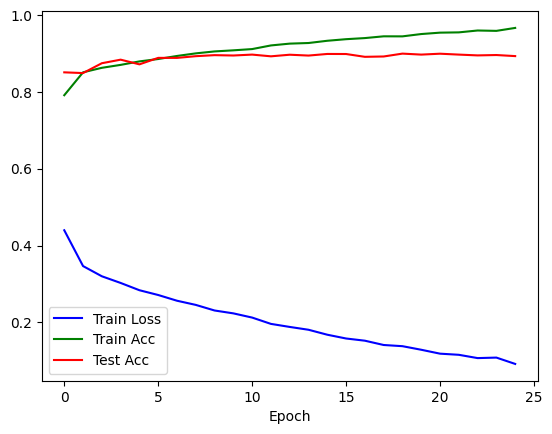

In [ ]:
#512, 24, 32
lr, num_epochs = 0.005, 25

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=25)

train_model(lstm_model, train_iter, test_iter, train_dataset.vocab, num_epochs, criterion, optimizer, scheduler, 1, device, True, '../models/best_LSTM_512_32_HAN.pt', '../models/final_LSTM_512_32_HAN.pt')

100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.4714697624182762, train_acc: 0.77064, test_acc: 0.85308


100%|██████████| 391/391 [00:32<00:00, 11.89it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.35584160517853547, train_acc: 0.84556, test_acc: 0.86008


100%|██████████| 391/391 [00:32<00:00, 11.85it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.3276814226527958, train_acc: 0.85852, test_acc: 0.86016


100%|██████████| 391/391 [00:33<00:00, 11.81it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.31012785053619035, train_acc: 0.86828, test_acc: 0.8706


100%|██████████| 391/391 [00:33<00:00, 11.82it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.29991719107646164, train_acc: 0.87296, test_acc: 0.88004


100%|██████████| 391/391 [00:32<00:00, 11.85it/s]


Best Model Saved at epoch 6
Epoch 6 completed, train_loss: 0.2844273407593408, train_acc: 0.87912, test_acc: 0.88636


100%|██████████| 391/391 [00:32<00:00, 11.92it/s]


Epoch 7 completed, train_loss: 0.27411724405977733, train_acc: 0.88536, test_acc: 0.87896


100%|██████████| 391/391 [00:32<00:00, 11.89it/s]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.2612501497540023, train_acc: 0.89088, test_acc: 0.89156


100%|██████████| 391/391 [00:32<00:00, 11.91it/s]


Epoch 9 completed, train_loss: 0.2512460408918083, train_acc: 0.89716, test_acc: 0.89112


100%|██████████| 391/391 [00:32<00:00, 11.93it/s]


Epoch 10 completed, train_loss: 0.24499109475051656, train_acc: 0.89872, test_acc: 0.88476


100%|██████████| 391/391 [00:33<00:00, 11.75it/s]


Epoch 11 completed, train_loss: 0.23309346673357517, train_acc: 0.90432, test_acc: 0.8746


100%|██████████| 391/391 [00:34<00:00, 11.36it/s]


Best Model Saved at epoch 12
Epoch 12 completed, train_loss: 0.22210269589024736, train_acc: 0.90856, test_acc: 0.8944


100%|██████████| 391/391 [00:33<00:00, 11.73it/s]


Epoch 13 completed, train_loss: 0.21620263357449065, train_acc: 0.91112, test_acc: 0.89392


100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Best Model Saved at epoch 14
Epoch 14 completed, train_loss: 0.20572797957893527, train_acc: 0.91528, test_acc: 0.89816


100%|██████████| 391/391 [00:34<00:00, 11.39it/s]


Best Model Saved at epoch 15
Epoch 15 completed, train_loss: 0.19672557035141894, train_acc: 0.92008, test_acc: 0.89968


100%|██████████| 391/391 [00:33<00:00, 11.74it/s]


Epoch 16 completed, train_loss: 0.18651129151968396, train_acc: 0.92564, test_acc: 0.89956


100%|██████████| 391/391 [00:35<00:00, 11.13it/s]


Epoch 17 completed, train_loss: 0.18291191718614924, train_acc: 0.92624, test_acc: 0.89556


100%|██████████| 391/391 [00:35<00:00, 11.01it/s]


Best Model Saved at epoch 18
Epoch 18 completed, train_loss: 0.17422605892333687, train_acc: 0.93256, test_acc: 0.90308


100%|██████████| 391/391 [00:35<00:00, 10.90it/s]


Epoch 19 completed, train_loss: 0.1651252620207989, train_acc: 0.9352, test_acc: 0.89112


100%|██████████| 391/391 [00:34<00:00, 11.25it/s]


Epoch 20 completed, train_loss: 0.15873283228796461, train_acc: 0.93732, test_acc: 0.89368


100%|██████████| 391/391 [00:34<00:00, 11.17it/s]


Epoch 21 completed, train_loss: 0.14705702494782255, train_acc: 0.9442, test_acc: 0.89844


100%|██████████| 391/391 [00:35<00:00, 11.01it/s]


Epoch 22 completed, train_loss: 0.1439453412580978, train_acc: 0.94308, test_acc: 0.89608


100%|██████████| 391/391 [00:35<00:00, 11.08it/s]


Epoch 23 completed, train_loss: 0.13525211554773323, train_acc: 0.94624, test_acc: 0.89328


100%|██████████| 391/391 [00:36<00:00, 10.86it/s]


Epoch 24 completed, train_loss: 0.12896863101979197, train_acc: 0.94932, test_acc: 0.89532


100%|██████████| 391/391 [00:36<00:00, 10.73it/s]

Epoch 25 completed, train_loss: 0.12210944011007123, train_acc: 0.95224, test_acc: 0.89808


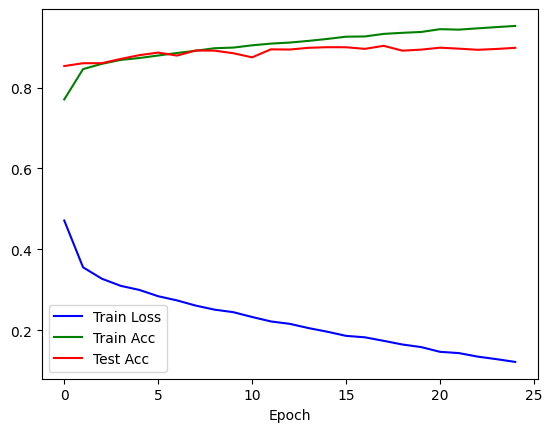

In [ ]:
#512, 24, 64
lr, num_epochs = 0.005, 25

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=25)

train_model(lstm_model, train_iter, test_iter, train_dataset.vocab, num_epochs, criterion, optimizer, scheduler, 1, device, True, '../models/best_LSTM_512_64_HAN.pt', '../models/final_LSTM_512_64_HAN.pt')

100%|██████████| 391/391 [00:32<00:00, 12.02it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.6115917792862944, train_acc: 0.6606, test_acc: 0.74908


100%|██████████| 391/391 [00:32<00:00, 12.03it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.4567228083872734, train_acc: 0.78872, test_acc: 0.81824


100%|██████████| 391/391 [00:32<00:00, 12.17it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.4061252652379253, train_acc: 0.81888, test_acc: 0.83504


100%|██████████| 391/391 [00:31<00:00, 12.23it/s]


Epoch 4 completed, train_loss: 0.3788360190742156, train_acc: 0.8348, test_acc: 0.83056


100%|██████████| 391/391 [00:31<00:00, 12.22it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.36165354513298825, train_acc: 0.84188, test_acc: 0.85628


100%|██████████| 391/391 [00:32<00:00, 12.16it/s]


Best Model Saved at epoch 6
Epoch 6 completed, train_loss: 0.3482746594321087, train_acc: 0.84936, test_acc: 0.86064


100%|██████████| 391/391 [00:32<00:00, 12.08it/s]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.34355371382535266, train_acc: 0.85008, test_acc: 0.8616


100%|██████████| 391/391 [00:32<00:00, 12.20it/s]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.3368681902470796, train_acc: 0.85468, test_acc: 0.8674


100%|██████████| 391/391 [00:32<00:00, 12.16it/s]


Best Model Saved at epoch 9
Epoch 9 completed, train_loss: 0.32859277149752886, train_acc: 0.8586, test_acc: 0.86828


100%|██████████| 391/391 [00:32<00:00, 12.12it/s]


Epoch 10 completed, train_loss: 0.32442047083011977, train_acc: 0.86132, test_acc: 0.86504


100%|██████████| 391/391 [00:32<00:00, 12.08it/s]


Epoch 11 completed, train_loss: 0.3226648234116757, train_acc: 0.86288, test_acc: 0.8666


100%|██████████| 391/391 [00:32<00:00, 12.17it/s]


Epoch 12 completed, train_loss: 0.3204133256774424, train_acc: 0.86256, test_acc: 0.86132


100%|██████████| 391/391 [00:32<00:00, 12.09it/s]


Epoch 13 completed, train_loss: 0.309774921259002, train_acc: 0.86648, test_acc: 0.8672


100%|██████████| 391/391 [00:31<00:00, 12.24it/s]


Best Model Saved at epoch 14
Epoch 14 completed, train_loss: 0.31021344131978273, train_acc: 0.86684, test_acc: 0.87464


100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


Epoch 15 completed, train_loss: 0.3045211741534036, train_acc: 0.87132, test_acc: 0.87372


100%|██████████| 391/391 [00:32<00:00, 12.19it/s]


Best Model Saved at epoch 16
Epoch 16 completed, train_loss: 0.30002220729580314, train_acc: 0.87308, test_acc: 0.87844


100%|██████████| 391/391 [00:32<00:00, 12.15it/s]


Best Model Saved at epoch 17
Epoch 17 completed, train_loss: 0.2956665889800662, train_acc: 0.87572, test_acc: 0.88144


100%|██████████| 391/391 [00:31<00:00, 12.29it/s]


Epoch 18 completed, train_loss: 0.2925694278057884, train_acc: 0.87564, test_acc: 0.86964


100%|██████████| 391/391 [00:32<00:00, 12.09it/s]


Epoch 19 completed, train_loss: 0.28961085884467413, train_acc: 0.8764, test_acc: 0.87648


100%|██████████| 391/391 [00:32<00:00, 12.20it/s]


Epoch 20 completed, train_loss: 0.28741343353715393, train_acc: 0.8768, test_acc: 0.87704


100%|██████████| 391/391 [00:32<00:00, 12.06it/s]


Epoch 21 completed, train_loss: 0.28333967209548294, train_acc: 0.88112, test_acc: 0.8722


100%|██████████| 391/391 [00:32<00:00, 12.13it/s]


Best Model Saved at epoch 22
Epoch 22 completed, train_loss: 0.2813135391039312, train_acc: 0.88084, test_acc: 0.88484


100%|██████████| 391/391 [00:32<00:00, 12.19it/s]


Epoch 23 completed, train_loss: 0.28338095185625584, train_acc: 0.8802, test_acc: 0.88044


100%|██████████| 391/391 [00:32<00:00, 12.03it/s]


Epoch 24 completed, train_loss: 0.2745689145668083, train_acc: 0.88312, test_acc: 0.87072


100%|██████████| 391/391 [00:32<00:00, 12.17it/s]

Best Model Saved at epoch 25
Epoch 25 completed, train_loss: 0.2752696958649189, train_acc: 0.88328, test_acc: 0.88668


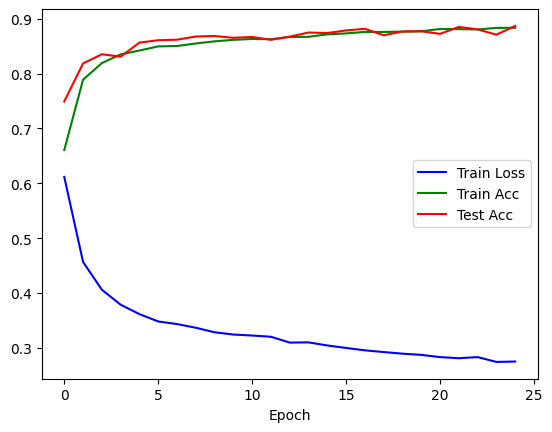

In [16]:
#512, 24, 64
lr, num_epochs = 0.001, 25

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=25)

train_model(lstm_model, train_iter, test_iter, train_dataset.vocab, num_epochs, criterion, optimizer, scheduler, 1, device, True, '../models/best_LSTM_512_64_1HAN.pt', '../models/final_LSTM_512_64_1HAN.pt')

100%|██████████| 391/391 [00:36<00:00, 10.79it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.4389121789304192, train_acc: 0.78864, test_acc: 0.851


100%|██████████| 391/391 [00:35<00:00, 10.98it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.34088617439388924, train_acc: 0.85416, test_acc: 0.86516


100%|██████████| 391/391 [00:34<00:00, 11.25it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.3102992845084661, train_acc: 0.867, test_acc: 0.88124


100%|██████████| 391/391 [00:34<00:00, 11.42it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.2899438277687258, train_acc: 0.87776, test_acc: 0.88656


100%|██████████| 391/391 [00:34<00:00, 11.22it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.27425295446077574, train_acc: 0.88408, test_acc: 0.88772


100%|██████████| 391/391 [00:34<00:00, 11.45it/s]


Best Model Saved at epoch 6
Epoch 6 completed, train_loss: 0.26237064247469766, train_acc: 0.89152, test_acc: 0.89332


100%|██████████| 391/391 [00:34<00:00, 11.26it/s]


Epoch 7 completed, train_loss: 0.24467888792686146, train_acc: 0.8992, test_acc: 0.885


100%|██████████| 391/391 [00:35<00:00, 10.97it/s]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.22996648353383975, train_acc: 0.90428, test_acc: 0.89716


100%|██████████| 391/391 [00:35<00:00, 10.99it/s]


Epoch 9 completed, train_loss: 0.2234337367403233, train_acc: 0.90796, test_acc: 0.89396


100%|██████████| 391/391 [00:34<00:00, 11.46it/s]


Epoch 10 completed, train_loss: 0.20947239275478646, train_acc: 0.91588, test_acc: 0.89684


100%|██████████| 391/391 [00:33<00:00, 11.52it/s]


Best Model Saved at epoch 11
Epoch 11 completed, train_loss: 0.19668751309061294, train_acc: 0.92176, test_acc: 0.9004


100%|██████████| 391/391 [00:34<00:00, 11.38it/s]


Epoch 12 completed, train_loss: 0.18490939139557616, train_acc: 0.92644, test_acc: 0.8998


100%|██████████| 391/391 [00:34<00:00, 11.41it/s]


Best Model Saved at epoch 13
Epoch 13 completed, train_loss: 0.1683642835072849, train_acc: 0.93332, test_acc: 0.901


100%|██████████| 391/391 [00:34<00:00, 11.44it/s]


Epoch 14 completed, train_loss: 0.15994623235767455, train_acc: 0.93644, test_acc: 0.8978


100%|██████████| 391/391 [00:34<00:00, 11.20it/s]


Epoch 15 completed, train_loss: 0.14723709042724745, train_acc: 0.94148, test_acc: 0.89344


100%|██████████| 391/391 [00:34<00:00, 11.43it/s]


Epoch 16 completed, train_loss: 0.13928671211690244, train_acc: 0.94616, test_acc: 0.89872


100%|██████████| 391/391 [00:34<00:00, 11.38it/s]


Best Model Saved at epoch 17
Epoch 17 completed, train_loss: 0.1291587177301993, train_acc: 0.94944, test_acc: 0.902


100%|██████████| 391/391 [00:35<00:00, 11.08it/s]


Epoch 18 completed, train_loss: 0.11765808488725854, train_acc: 0.95476, test_acc: 0.89964


100%|██████████| 391/391 [00:35<00:00, 10.91it/s]


Epoch 19 completed, train_loss: 0.11273046275434058, train_acc: 0.95484, test_acc: 0.89728


100%|██████████| 391/391 [00:36<00:00, 10.57it/s]


Epoch 20 completed, train_loss: 0.1030416439889985, train_acc: 0.95984, test_acc: 0.89988


100%|██████████| 391/391 [00:36<00:00, 10.83it/s]


Epoch 21 completed, train_loss: 0.09593739688082044, train_acc: 0.96252, test_acc: 0.90016


100%|██████████| 391/391 [00:36<00:00, 10.82it/s]


Epoch 22 completed, train_loss: 0.08453194578976163, train_acc: 0.96636, test_acc: 0.90048


100%|██████████| 391/391 [00:33<00:00, 11.50it/s]


Epoch 23 completed, train_loss: 0.08587235939996246, train_acc: 0.96732, test_acc: 0.8906


100%|██████████| 391/391 [00:36<00:00, 10.84it/s]


Epoch 24 completed, train_loss: 0.07588842206532159, train_acc: 0.97064, test_acc: 0.89752


100%|██████████| 391/391 [00:34<00:00, 11.42it/s]

Epoch 25 completed, train_loss: 0.07664122226436043, train_acc: 0.9714, test_acc: 0.89892


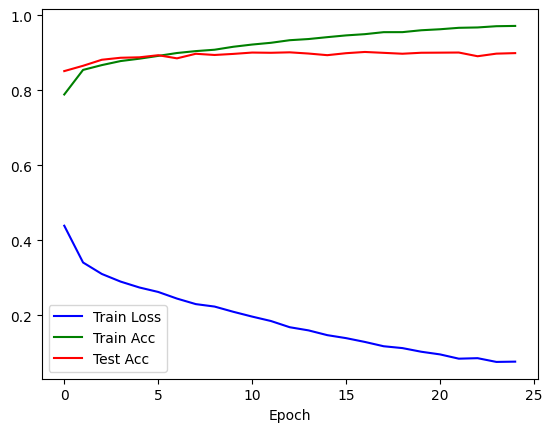

In [ ]:
#512, 24, 64
lr, num_epochs = 0.01, 25

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=25)

train_model(lstm_model, train_iter, test_iter, train_dataset.vocab, num_epochs, criterion, optimizer, scheduler, 1, device, True, '../models/best_LSTM_512_64_2HAN.pt', '../models/final_LSTM_512_64_2HAN.pt')

100%|██████████| 391/391 [00:31<00:00, 12.24it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.4154845805424254, train_acc: 0.8042, test_acc: 0.86528


100%|██████████| 391/391 [00:32<00:00, 12.20it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.3138207431568209, train_acc: 0.86892, test_acc: 0.88536


100%|██████████| 391/391 [00:31<00:00, 12.22it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.28119072859244576, train_acc: 0.8844, test_acc: 0.89116


100%|██████████| 391/391 [00:31<00:00, 12.26it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.2531803721547737, train_acc: 0.896, test_acc: 0.8962


100%|██████████| 391/391 [00:31<00:00, 12.22it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.24100962220250494, train_acc: 0.90216, test_acc: 0.89828


100%|██████████| 391/391 [00:31<00:00, 12.30it/s]


Epoch 6 completed, train_loss: 0.21223790755928934, train_acc: 0.91576, test_acc: 0.89736


100%|██████████| 391/391 [00:32<00:00, 12.12it/s]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.20107144171662647, train_acc: 0.91912, test_acc: 0.902


100%|██████████| 391/391 [00:31<00:00, 12.30it/s]


Epoch 8 completed, train_loss: 0.19107065090666647, train_acc: 0.92428, test_acc: 0.9008


100%|██████████| 391/391 [00:31<00:00, 12.23it/s]


Epoch 9 completed, train_loss: 0.17456510136156436, train_acc: 0.92972, test_acc: 0.90084


100%|██████████| 391/391 [00:31<00:00, 12.35it/s]


Epoch 10 completed, train_loss: 0.16201218552029956, train_acc: 0.93504, test_acc: 0.89804


100%|██████████| 391/391 [00:31<00:00, 12.25it/s]


Epoch 11 completed, train_loss: 0.1581855412629788, train_acc: 0.93848, test_acc: 0.8984


100%|██████████| 391/391 [00:31<00:00, 12.33it/s]


Best Model Saved at epoch 12
Epoch 12 completed, train_loss: 0.14506854657607768, train_acc: 0.94328, test_acc: 0.90404


100%|██████████| 391/391 [00:31<00:00, 12.34it/s]


Epoch 13 completed, train_loss: 0.1317571920611898, train_acc: 0.94728, test_acc: 0.90016


100%|██████████| 391/391 [00:31<00:00, 12.38it/s]


Epoch 14 completed, train_loss: 0.13558327047454427, train_acc: 0.9462, test_acc: 0.89904


100%|██████████| 391/391 [00:31<00:00, 12.30it/s]


Epoch 15 completed, train_loss: 0.12599376463771933, train_acc: 0.952, test_acc: 0.89788


100%|██████████| 391/391 [00:31<00:00, 12.44it/s]


Epoch 16 completed, train_loss: 0.11905242976687296, train_acc: 0.95376, test_acc: 0.89812


100%|██████████| 391/391 [00:31<00:00, 12.28it/s]


Epoch 17 completed, train_loss: 0.11276182024965963, train_acc: 0.95484, test_acc: 0.89776


100%|██████████| 391/391 [00:31<00:00, 12.31it/s]


Epoch 18 completed, train_loss: 0.11260172049693591, train_acc: 0.95684, test_acc: 0.89892


100%|██████████| 391/391 [00:32<00:00, 12.20it/s]


Epoch 19 completed, train_loss: 0.10652564921418724, train_acc: 0.9586, test_acc: 0.90168


100%|██████████| 391/391 [00:31<00:00, 12.35it/s]


Epoch 20 completed, train_loss: 0.10693133522844528, train_acc: 0.95996, test_acc: 0.901


100%|██████████| 391/391 [00:31<00:00, 12.30it/s]


Epoch 21 completed, train_loss: 0.10374592737201839, train_acc: 0.959, test_acc: 0.90216


100%|██████████| 391/391 [00:31<00:00, 12.29it/s]


Epoch 22 completed, train_loss: 0.09627774610753408, train_acc: 0.96344, test_acc: 0.89796


100%|██████████| 391/391 [00:31<00:00, 12.32it/s]


Epoch 23 completed, train_loss: 0.09789175343940325, train_acc: 0.96244, test_acc: 0.9034


100%|██████████| 391/391 [00:31<00:00, 12.28it/s]


Epoch 24 completed, train_loss: 0.09542641710118412, train_acc: 0.96356, test_acc: 0.89964


100%|██████████| 391/391 [00:31<00:00, 12.34it/s]

Epoch 25 completed, train_loss: 0.09459388585013273, train_acc: 0.965, test_acc: 0.90032


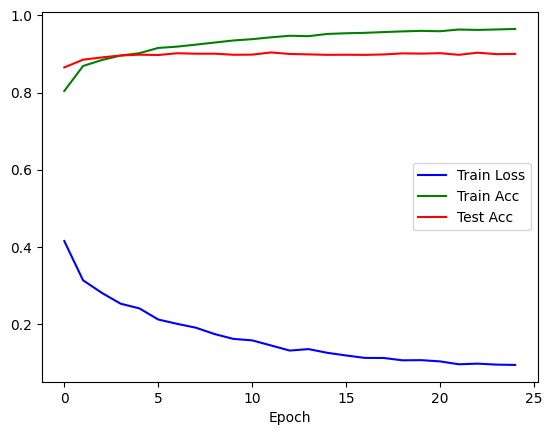

In [18]:
#512, 24, 64
lr, num_epochs = 0.005, 25

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

train_model(lstm_model, train_iter, test_iter, train_dataset.vocab, num_epochs, criterion, optimizer, None, 1, device, True, '../models/best_LSTM_512_64_3HAN.pt', '../models/final_LSTM_512_64_3HAN.pt')

100%|██████████| 196/196 [00:33<00:00,  5.91it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.469504821893512, train_acc: 0.77032, test_acc: 0.83708


100%|██████████| 196/196 [00:33<00:00,  5.91it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.3617664150589583, train_acc: 0.84192, test_acc: 0.85816


100%|██████████| 196/196 [00:33<00:00,  5.89it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.34106024309080474, train_acc: 0.84968, test_acc: 0.861


100%|██████████| 196/196 [00:32<00:00,  6.00it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.3207244334020177, train_acc: 0.86064, test_acc: 0.86776


100%|██████████| 196/196 [00:32<00:00,  6.02it/s]


Epoch 5 completed, train_loss: 0.3175584091519823, train_acc: 0.86348, test_acc: 0.85664


100%|██████████| 196/196 [00:32<00:00,  6.02it/s]


Best Model Saved at epoch 6
Epoch 6 completed, train_loss: 0.29850809435759273, train_acc: 0.87496, test_acc: 0.87848


100%|██████████| 196/196 [00:32<00:00,  5.98it/s]


Epoch 7 completed, train_loss: 0.2949936159563308, train_acc: 0.87364, test_acc: 0.87324


100%|██████████| 196/196 [00:32<00:00,  5.98it/s]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.27618525184843007, train_acc: 0.88308, test_acc: 0.88412


100%|██████████| 196/196 [00:32<00:00,  6.03it/s]


Best Model Saved at epoch 9
Epoch 9 completed, train_loss: 0.2698323368570026, train_acc: 0.88684, test_acc: 0.88848


100%|██████████| 196/196 [00:32<00:00,  6.02it/s]


Best Model Saved at epoch 10
Epoch 10 completed, train_loss: 0.2615535979216196, train_acc: 0.8924, test_acc: 0.88988


100%|██████████| 196/196 [00:31<00:00,  6.14it/s]


Best Model Saved at epoch 11
Epoch 11 completed, train_loss: 0.2564538711187791, train_acc: 0.89484, test_acc: 0.89108


100%|██████████| 196/196 [00:31<00:00,  6.28it/s]


Best Model Saved at epoch 12
Epoch 12 completed, train_loss: 0.24831117081398868, train_acc: 0.89728, test_acc: 0.89204


100%|██████████| 196/196 [00:32<00:00,  5.97it/s]


Epoch 13 completed, train_loss: 0.24368606393738668, train_acc: 0.89804, test_acc: 0.88488


100%|██████████| 196/196 [00:32<00:00,  6.08it/s]


Best Model Saved at epoch 14
Epoch 14 completed, train_loss: 0.23429771322680978, train_acc: 0.90448, test_acc: 0.89304


100%|██████████| 196/196 [00:34<00:00,  5.62it/s]


Epoch 15 completed, train_loss: 0.22458931176486063, train_acc: 0.90932, test_acc: 0.89244


100%|██████████| 196/196 [00:32<00:00,  5.97it/s]


Best Model Saved at epoch 16
Epoch 16 completed, train_loss: 0.22852026215013194, train_acc: 0.90604, test_acc: 0.89492


100%|██████████| 196/196 [00:32<00:00,  5.98it/s]


Epoch 17 completed, train_loss: 0.21236601297040375, train_acc: 0.91416, test_acc: 0.8926


100%|██████████| 196/196 [00:32<00:00,  6.06it/s]


Best Model Saved at epoch 18
Epoch 18 completed, train_loss: 0.20841631692435061, train_acc: 0.9142, test_acc: 0.89564


100%|██████████| 196/196 [00:32<00:00,  6.02it/s]


Best Model Saved at epoch 19
Epoch 19 completed, train_loss: 0.2031810921901951, train_acc: 0.91796, test_acc: 0.89972


100%|██████████| 196/196 [00:32<00:00,  6.03it/s]


Epoch 20 completed, train_loss: 0.19356660544872284, train_acc: 0.92188, test_acc: 0.89812


100%|██████████| 196/196 [00:33<00:00,  5.83it/s]


Epoch 21 completed, train_loss: 0.1919061690568924, train_acc: 0.923, test_acc: 0.89292


100%|██████████| 196/196 [00:32<00:00,  6.06it/s]


Epoch 22 completed, train_loss: 0.18222715954619403, train_acc: 0.92836, test_acc: 0.8954


100%|██████████| 196/196 [00:32<00:00,  6.09it/s]


Best Model Saved at epoch 23
Epoch 23 completed, train_loss: 0.17530204232173915, train_acc: 0.93216, test_acc: 0.90052


100%|██████████| 196/196 [00:32<00:00,  6.01it/s]


Epoch 24 completed, train_loss: 0.1691950715089939, train_acc: 0.93148, test_acc: 0.89868


100%|██████████| 196/196 [00:32<00:00,  5.97it/s]


Epoch 25 completed, train_loss: 0.1632033651124458, train_acc: 0.9352, test_acc: 0.89668


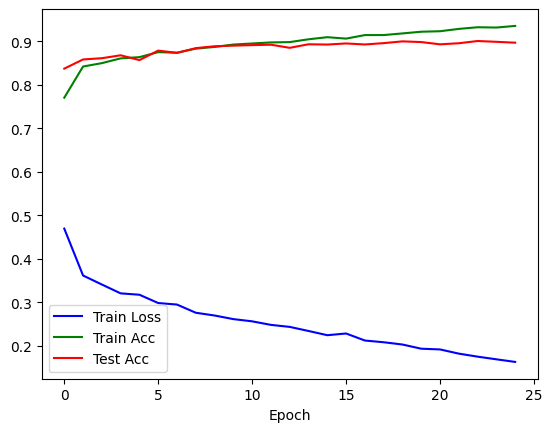

In [ ]:
#512, 24, 128
lr, num_epochs = 0.005, 25

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=25)

train_model(lstm_model, train_iter, test_iter, train_dataset.vocab, num_epochs, criterion, optimizer, scheduler, 1, device, True, '../models/best_LSTM_512_128_HAN.pt', '../models/final_LSTM_512_128_HAN.pt')

### GRU

100%|██████████| 391/391 [00:33<00:00, 11.54it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.4501591087759608, train_acc: 0.78244, test_acc: 0.85284


100%|██████████| 391/391 [00:33<00:00, 11.58it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.3556979967810004, train_acc: 0.84564, test_acc: 0.8618


100%|██████████| 391/391 [00:34<00:00, 11.49it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.32643954265300573, train_acc: 0.8608, test_acc: 0.872


100%|██████████| 391/391 [00:32<00:00, 11.86it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.3121583674798536, train_acc: 0.86668, test_acc: 0.87568


100%|██████████| 391/391 [00:33<00:00, 11.76it/s]


Best Model Saved at epoch 5
Epoch 5 completed, train_loss: 0.29942624884493213, train_acc: 0.87416, test_acc: 0.88172


100%|██████████| 391/391 [00:33<00:00, 11.55it/s]


Epoch 6 completed, train_loss: 0.2858578623141474, train_acc: 0.87784, test_acc: 0.88012


100%|██████████| 391/391 [00:33<00:00, 11.77it/s]


Best Model Saved at epoch 7
Epoch 7 completed, train_loss: 0.27542975148581483, train_acc: 0.88392, test_acc: 0.88388


100%|██████████| 391/391 [00:32<00:00, 12.17it/s]


Epoch 8 completed, train_loss: 0.2664342849798825, train_acc: 0.88824, test_acc: 0.8568


100%|██████████| 391/391 [00:31<00:00, 12.25it/s]


Best Model Saved at epoch 9
Epoch 9 completed, train_loss: 0.25389961989791804, train_acc: 0.89688, test_acc: 0.89256


100%|██████████| 391/391 [00:31<00:00, 12.27it/s]


Epoch 10 completed, train_loss: 0.2504814497345244, train_acc: 0.89788, test_acc: 0.88832


100%|██████████| 391/391 [00:33<00:00, 11.73it/s]


Epoch 11 completed, train_loss: 0.24226800274208685, train_acc: 0.90096, test_acc: 0.89096


100%|██████████| 391/391 [00:33<00:00, 11.83it/s]


Best Model Saved at epoch 12
Epoch 12 completed, train_loss: 0.23801605186194105, train_acc: 0.9022, test_acc: 0.89568


100%|██████████| 391/391 [00:32<00:00, 11.86it/s]


Epoch 13 completed, train_loss: 0.22489918253915694, train_acc: 0.9088, test_acc: 0.89348


100%|██████████| 391/391 [00:31<00:00, 12.26it/s]


Best Model Saved at epoch 14
Epoch 14 completed, train_loss: 0.21501344499533134, train_acc: 0.913, test_acc: 0.897


100%|██████████| 391/391 [00:31<00:00, 12.30it/s]


Epoch 15 completed, train_loss: 0.2122229539867862, train_acc: 0.91416, test_acc: 0.89628


100%|██████████| 391/391 [00:32<00:00, 12.18it/s]


Epoch 16 completed, train_loss: 0.20324753924175296, train_acc: 0.91804, test_acc: 0.89156


100%|██████████| 391/391 [00:32<00:00, 12.11it/s]


Best Model Saved at epoch 17
Epoch 17 completed, train_loss: 0.19096466108127627, train_acc: 0.9256, test_acc: 0.89836


100%|██████████| 391/391 [00:32<00:00, 12.19it/s]


Epoch 18 completed, train_loss: 0.18524241715174197, train_acc: 0.92792, test_acc: 0.89676


100%|██████████| 391/391 [00:32<00:00, 12.20it/s]


Epoch 19 completed, train_loss: 0.17300720594327926, train_acc: 0.932, test_acc: 0.89684


100%|██████████| 391/391 [00:32<00:00, 12.07it/s]


Best Model Saved at epoch 20
Epoch 20 completed, train_loss: 0.17004287161904832, train_acc: 0.9332, test_acc: 0.90016


100%|██████████| 391/391 [00:32<00:00, 12.16it/s]


Epoch 21 completed, train_loss: 0.16137711161657062, train_acc: 0.9364, test_acc: 0.89968


100%|██████████| 391/391 [00:32<00:00, 12.17it/s]


Epoch 22 completed, train_loss: 0.15392426884425875, train_acc: 0.94048, test_acc: 0.89764


100%|██████████| 391/391 [00:32<00:00, 11.96it/s]


Epoch 23 completed, train_loss: 0.14652264695090558, train_acc: 0.9438, test_acc: 0.89776


100%|██████████| 391/391 [00:33<00:00, 11.78it/s]


Epoch 24 completed, train_loss: 0.13884296118165068, train_acc: 0.94536, test_acc: 0.893


100%|██████████| 391/391 [00:32<00:00, 11.90it/s]


Epoch 25 completed, train_loss: 0.13766490585168303, train_acc: 0.94652, test_acc: 0.89856


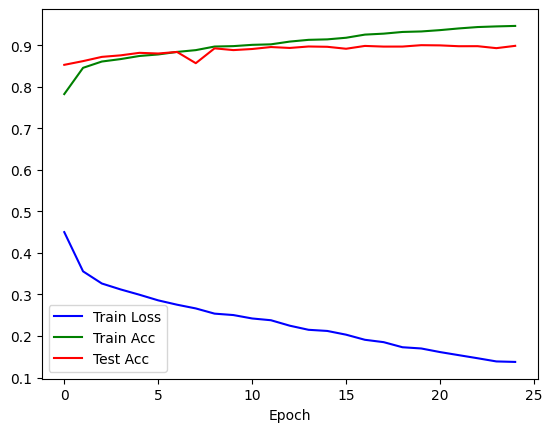

In [ ]:
#256, 24, 64
lr, num_epochs = 0.005, 25

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=25)

train_model(gru_model, train_iter, test_iter, train_dataset.vocab, num_epochs, criterion, optimizer, scheduler, 0.5, device, True, '../models/best_GRU_256_64_HAN.pt', '../models/final_GRU_256_64_HAN.pt')

100%|██████████| 391/391 [00:34<00:00, 11.19it/s]


Best Model Saved at epoch 1
Epoch 1 completed, train_loss: 0.4309590232494237, train_acc: 0.79952, test_acc: 0.85072


100%|██████████| 391/391 [00:34<00:00, 11.25it/s]


Best Model Saved at epoch 2
Epoch 2 completed, train_loss: 0.3522396059825902, train_acc: 0.8458, test_acc: 0.86472


100%|██████████| 391/391 [00:35<00:00, 11.03it/s]


Best Model Saved at epoch 3
Epoch 3 completed, train_loss: 0.3323538070139678, train_acc: 0.85732, test_acc: 0.87328


100%|██████████| 391/391 [00:34<00:00, 11.33it/s]


Best Model Saved at epoch 4
Epoch 4 completed, train_loss: 0.3131742028095533, train_acc: 0.86648, test_acc: 0.87688


100%|██████████| 391/391 [00:34<00:00, 11.20it/s]


Epoch 5 completed, train_loss: 0.30481129983806854, train_acc: 0.87092, test_acc: 0.86724


100%|██████████| 391/391 [00:35<00:00, 11.10it/s]


Best Model Saved at epoch 6
Epoch 6 completed, train_loss: 0.2902869545590237, train_acc: 0.87732, test_acc: 0.88004


100%|██████████| 391/391 [00:35<00:00, 11.11it/s]


Epoch 7 completed, train_loss: 0.2803678235510731, train_acc: 0.88192, test_acc: 0.87616


100%|██████████| 391/391 [00:34<00:00, 11.37it/s]


Best Model Saved at epoch 8
Epoch 8 completed, train_loss: 0.2680769882276845, train_acc: 0.88736, test_acc: 0.88592


100%|██████████| 391/391 [00:34<00:00, 11.36it/s]


Best Model Saved at epoch 9
Epoch 9 completed, train_loss: 0.261589895638511, train_acc: 0.89168, test_acc: 0.89092


100%|██████████| 391/391 [00:34<00:00, 11.26it/s]


Epoch 10 completed, train_loss: 0.2551230643411427, train_acc: 0.895, test_acc: 0.88452


100%|██████████| 391/391 [00:34<00:00, 11.20it/s]


Epoch 11 completed, train_loss: 0.2409500259610698, train_acc: 0.9034, test_acc: 0.89052


100%|██████████| 391/391 [00:34<00:00, 11.23it/s]


Epoch 12 completed, train_loss: 0.23433193021341966, train_acc: 0.90432, test_acc: 0.88116


100%|██████████| 391/391 [00:35<00:00, 11.15it/s]


Best Model Saved at epoch 13
Epoch 13 completed, train_loss: 0.22868973675095822, train_acc: 0.90616, test_acc: 0.89792


100%|██████████| 391/391 [00:34<00:00, 11.22it/s]


Epoch 14 completed, train_loss: 0.2178981101802548, train_acc: 0.91228, test_acc: 0.89552


100%|██████████| 391/391 [00:34<00:00, 11.20it/s]


Epoch 15 completed, train_loss: 0.21167743968231903, train_acc: 0.91376, test_acc: 0.8954


100%|██████████| 391/391 [00:35<00:00, 10.99it/s]


Epoch 16 completed, train_loss: 0.20295676425137482, train_acc: 0.91756, test_acc: 0.8972


100%|██████████| 391/391 [00:34<00:00, 11.18it/s]


Epoch 17 completed, train_loss: 0.19292221340300786, train_acc: 0.92416, test_acc: 0.89744


100%|██████████| 391/391 [00:35<00:00, 11.12it/s]


Epoch 18 completed, train_loss: 0.1841781587075547, train_acc: 0.92716, test_acc: 0.89512


100%|██████████| 391/391 [00:35<00:00, 11.00it/s]


Epoch 19 completed, train_loss: 0.17532707459252814, train_acc: 0.93152, test_acc: 0.89496


100%|██████████| 391/391 [00:35<00:00, 10.97it/s]


Epoch 20 completed, train_loss: 0.16861430669913208, train_acc: 0.93432, test_acc: 0.88956


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]


Best Model Saved at epoch 21
Epoch 21 completed, train_loss: 0.15421455158182726, train_acc: 0.93952, test_acc: 0.89804


100%|██████████| 391/391 [00:35<00:00, 11.01it/s]


Epoch 22 completed, train_loss: 0.15126592907911676, train_acc: 0.94012, test_acc: 0.8978


100%|██████████| 391/391 [00:33<00:00, 11.53it/s]


Epoch 23 completed, train_loss: 0.14327390800180184, train_acc: 0.9432, test_acc: 0.89456


100%|██████████| 391/391 [00:34<00:00, 11.38it/s]


Epoch 24 completed, train_loss: 0.13696594028007192, train_acc: 0.94624, test_acc: 0.89468


100%|██████████| 391/391 [00:35<00:00, 11.12it/s]


Epoch 25 completed, train_loss: 0.13463882239454467, train_acc: 0.94764, test_acc: 0.89788


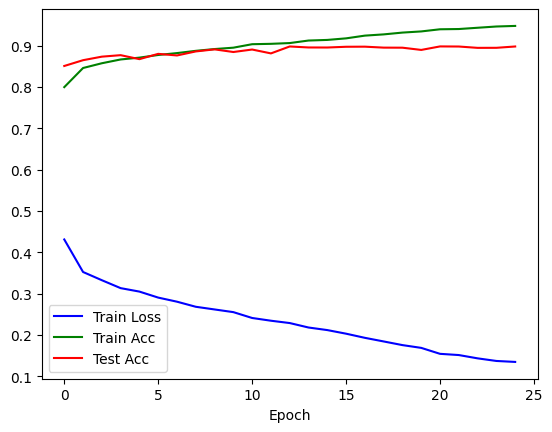

In [ ]:
#512, 24, 64
lr, num_epochs = 0.005, 25

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=25)

train_model(gru_model, train_iter, test_iter, train_dataset.vocab, num_epochs, criterion, optimizer, scheduler, 0.5, device, True, '../models/best_GRU_512_64_HAN.pt', '../models/final_GRU_512_64_HAN.pt')

### Evaluation on IMDB test dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_256_32_HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True, True, '../results/HAN.csv')

100%|██████████| 782/782 [00:48<00:00, 16.11it/s]


(0.90236, 0.91032, 0.8960548074651548, 0.903131076630025)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_256_64_HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 391/391 [00:35<00:00, 10.95it/s]


(0.90276, 0.90808, 0.8985197498614739, 0.9032745792384514)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_512_32_HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 391/391 [00:36<00:00, 10.86it/s]


(0.9002, 0.90368, 0.8974338603320887, 0.9005460995734843)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_512_64_HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 391/391 [00:35<00:00, 11.00it/s]


(0.90308, 0.91032, 0.8973267092500592, 0.9037766570032961)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_512_64_1HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 391/391 [00:35<00:00, 11.14it/s]


(0.88788, 0.88512, 0.8900329820609766, 0.8875696923508885)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_512_64_2HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 391/391 [00:36<00:00, 10.78it/s]


(0.902, 0.91816, 0.8894141351518909, 0.9035584947252401)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_512_64_3HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 391/391 [00:36<00:00, 10.70it/s]


(0.9022, 0.90128, 0.9029414121984451, 0.9021099411458542)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_512_128_HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 391/391 [00:36<00:00, 10.79it/s]


(0.90052, 0.91544, 0.8889147828788938, 0.9019824222598826)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gru_model = torch.load('../models/best_GRU_256_64_HAN.pt')
eval_model(gru_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 391/391 [00:36<00:00, 10.76it/s]


(0.90024, 0.90488, 0.8965599239061509, 0.9007007485268355)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gru_model = torch.load('../models/best_GRU_512_64_HAN.pt')
eval_model(gru_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 391/391 [00:35<00:00, 11.03it/s]


(0.89804, 0.9064, 0.891494216696829, 0.8988853187353723)

### Evaluation with the new test data

Since the test data is a csv, we will have to modify the _read_data function in the dataset

In [19]:
class TestIMDBDataset(Dataset):
    def __init__(self, 
                 csv_path:str,
                 max_sent_len:int,
                 max_doc_len:int, 
                 vocab:d2l.Vocab):
        """
        Test Dataset Class
        The dataset will be created by reading all documents inside the file, to which they will be preprocessed into lists of individual sentence and words for each review
        
        Args:
            csv_path (str): path to csv file
            max_sent_len (int): maximum number of words per sentence in review
            max_doc_len (int): maximum number of sentences per review
            vocab (d2l.Vocab): d2l Vocab of train dat
        """
        self.data_list, self.label_list = self._read_data(csv_path)
        self.max_sent_len = max_sent_len
        self.max_doc_len = max_doc_len
        self.vocab = d2l.Vocab(d2l.tokenize(self.data_list, token='word'), min_freq=5, reserved_tokens=['<pad>']) if vocab == None else vocab
    

    def _read_data(self, csv_path):
        dataset = pd.read_csv(csv_path)
        data = dataset['text'].tolist()
        labels = dataset['label'].tolist()
        return data, labels


    def _transform_text(self, document:str):
        """
        Function to transform the dataset into the required format for HAN

        Args:
            document (str): the review

        Returns:
            doc: nested array of the review, in the format of [[word idx for each word in sentence], [next sentence], ...]
            num_sents: retrieve the number of sentences in document
            num_word: max number of words across all sentence in document
        """
        # Encoding document with max sentence length and maximum document length (num sentence)
        # Split into individual sentences in document
        sentences = sent_tokenize(document)
        doc = [self.vocab[word_tokenize(sentence)] for sentence in sentences]
        doc = [sent[:self.max_sent_len] for sent in doc][:self.max_doc_len]
        num_sents = min(len(doc), self.max_doc_len) # There is a limit of max_doc_len

        # skip erroneous ones
        if not num_sents:
            return None, -1, None

        num_words = [min(len(sent), self.max_sent_len) for sent in doc][:self.max_doc_len]
        return doc, num_sents, num_words

    
    def __len__(self):
        return len(self.data_list)


    def __getitem__(self, idx):
        doc_data = self.data_list[idx]
        doc, num_sents, num_words = self._transform_text(doc_data)
        if num_sents == -1:
            return None
        
        return doc, self.label_list[idx], num_sents, num_words

In [20]:
train_dataset = IMDBDataset(data_dir="../data/aclImdb",
                            max_sent_len=512,
                            max_doc_len=24)

test_dataset = TestIMDBDataset(csv_path="../data/test_data_movie.csv",
                                max_sent_len=512,
                                max_doc_len=24,
                                vocab=train_dataset.vocab)

In [21]:
train_iter = DataLoader(train_dataset,
                        batch_size=64, 
                        shuffle=True,
                        collate_fn = padAnnotations(
                            pad_idx = train_dataset.vocab.token_to_idx["<pad>"], 
                        ))

test_iter = DataLoader(test_dataset,
                        batch_size=64, 
                        collate_fn = padAnnotations(
                            pad_idx = train_dataset.vocab.token_to_idx["<pad>"], 
                        ))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_256_32_HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 1250/1250 [01:11<00:00, 17.52it/s]


(0.9395, 0.9443471297732846, 0.9351737126431084, 0.9397380347626874)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_256_64_HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 625/625 [00:54<00:00, 11.38it/s]


(0.936025, 0.9389419948951504, 0.9333830845771144, 0.9361542875676755)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_512_32_HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 1250/1250 [01:06<00:00, 18.89it/s]


(0.93895, 0.9409939442470346, 0.9370545726389234, 0.9390201268541177)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_512_64_HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 625/625 [00:55<00:00, 11.26it/s]


(0.93275, 0.9385416145338071, 0.9276774672273065, 0.933077918200816)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_512_64_1HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 625/625 [00:53<00:00, 11.58it/s]


(0.896425, 0.8869425954656924, 0.9039069672549219, 0.8953444312526839)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_512_64_2HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 625/625 [00:55<00:00, 11.30it/s]


(0.94025, 0.9514038336419599, 0.9305399187429634, 0.9408562237070032)

In [24]:
# Best Result
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_512_64_3HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True, True, '../results/HAN.csv')

100%|██████████| 625/625 [01:02<00:00, 10.03it/s]


(0.940525, 0.943596416595766, 0.9377300308365663, 0.9406540773816948)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = torch.load('../models/best_LSTM_512_128_HAN.pt')
eval_model(lstm_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 311/311 [00:52<00:00,  5.97it/s]


(0.928975, 0.9404934687953556, 0.9191938955194678, 0.929721706864564)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gru_model = torch.load('../models/best_GRU_256_64_HAN.pt')
eval_model(gru_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 625/625 [00:57<00:00, 10.89it/s]


(0.93205, 0.9347880486462139, 0.9295774647887324, 0.9321754753705644)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gru_model = torch.load('../models/best_GRU_512_64_HAN.pt')
eval_model(gru_model, test_iter, device, train_dataset.vocab, True)

100%|██████████| 625/625 [00:55<00:00, 11.19it/s]


(0.93285, 0.9383414243531355, 0.9280304905212097, 0.933157475612184)